# SAC vs ObsPy — Equivalent Processing Workflow (ObsPy Notebook)

This notebook mirrors a typical SAC macro:

1. Read waveform files (SAC or MiniSEED)
2. Demean, detrend, taper
3. Bandpass filter (zero-phase)
4. (Optional) decimate / resample
5. Plot before/after
6. Write outputs back to SAC (or other formats)

**Edit the configuration cell below** (glob, filter band, output mode).


In [1]:
# --- Configuration (edit me) ---
from pathlib import Path

INPUT_GLOB = "data/local/*.sac"      # e.g., "*.SAC" or "*.mseed"
OUT_DIR = Path("data/local/processed")
OVERWRITE = False         # True to overwrite original files (be careful!)
SUFFIX = ".bp_1_10"       # appended to filename stem if not overwriting

# Bandpass settings (Hz)
FREQMIN = 1.0
FREQMAX = 10.0
CORNERS = 4
ZEROPHASE = True          # SAC bp ... p 2 ~ zerophase

# Preprocessing
TAPER_MAX_PERCENTAGE = 0.05

# Optional decimation (set to None to disable)
DECIMATE_FACTOR = None    # e.g., 2, 4, 5

OUT_DIR


PosixPath('data/local/processed')

In [2]:
# --- Imports ---
# from obspy import read
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt

# (Optional) for nicer plots of many traces, you can use st.plot()


In [3]:
# --- Discover files ---
files = sorted(Path(".").glob(INPUT_GLOB))
if not files:
    raise FileNotFoundError(f"No files match {INPUT_GLOB!r} in {Path('.').resolve()}")

print(f"Found {len(files)} file(s). Showing first 10:")
for fn in files[:10]:
    print(" ", fn)


Found 3 file(s). Showing first 10:
  data/local/2025.355.16.59.01.0000.WW.IRMR.00.HHE.sac
  data/local/2025.355.16.59.01.0000.WW.IRMR.00.HHN.sac
  data/local/2025.355.16.59.01.0000.WW.IRMR.00.HHZ.sac


## Preview one file (raw)


Previewing data/local/2025.355.16.59.01.0000.WW.IRMR.00.HHZ.sac ...


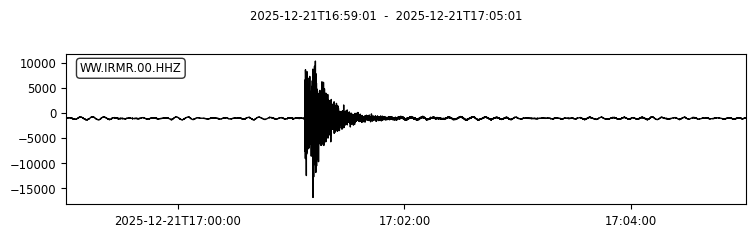

In [4]:
# Pick a file to preview
preview_fn = files[2]  # e.g., files[0]
print(f"\nPreviewing {preview_fn} ...")
st_raw = read(str(preview_fn))
st_raw.plot();  # interactive plot

## Define the processing function (ObsPy equivalent of the SAC macro)

In [5]:
def process_stream(st):
    """In-place processing to mirror the SAC macro steps."""
    # Demean + detrend
    st.detrend("demean")
    st.detrend("linear")

    # Taper
    st.taper(max_percentage=TAPER_MAX_PERCENTAGE)

    # Bandpass (SAC: bp c f1 f2 n 4 p 2)
    st.filter("bandpass",
              freqmin=FREQMIN, freqmax=FREQMAX,
              corners=CORNERS, zerophase=ZEROPHASE)

    # Optional decimation (with anti-aliasing filter)
    if DECIMATE_FACTOR is not None:
        st.decimate(factor=int(DECIMATE_FACTOR), no_filter=False)

    return st


## Batch process and write outputs

In [6]:
OUT_DIR.mkdir(exist_ok=True)

for fn in files:
    st = read(str(fn))
    st_proc = process_stream(st)

    # Decide output path
    if OVERWRITE:
        out_fn = fn
    else:
        out_fn = OUT_DIR / (fn.stem + SUFFIX + fn.suffix)

    # Write as SAC if the input is SAC; otherwise you can choose another format
    # ObsPy will infer format from extension poorly; so specify format explicitly for SAC:
    if fn.suffix.lower() == ".sac":
        st_proc.write(str(out_fn), format="SAC")
    else:
        # For MiniSEED example:
        st_proc.write(str(out_fn), format="MSEED")

    print(f"Wrote: {out_fn}")


Wrote: data/local/processed/2025.355.16.59.01.0000.WW.IRMR.00.HHE.bp_1_10.sac
Wrote: data/local/processed/2025.355.16.59.01.0000.WW.IRMR.00.HHN.bp_1_10.sac
Wrote: data/local/processed/2025.355.16.59.01.0000.WW.IRMR.00.HHZ.bp_1_10.sac


## Compare before/after on one example

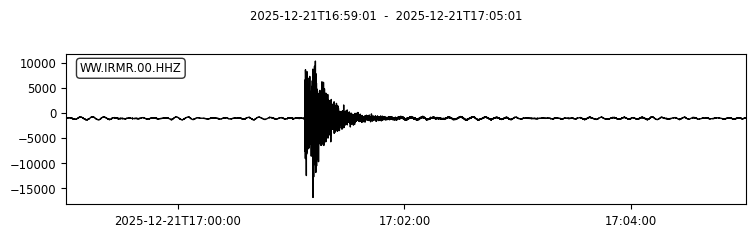

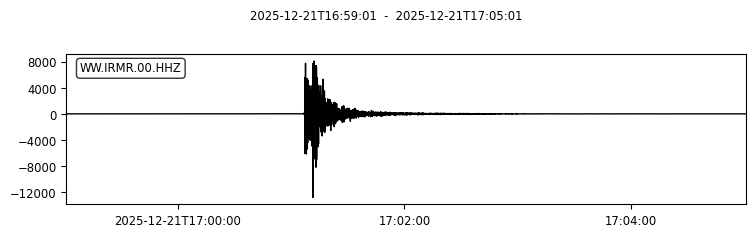

WW.IRMR.00.HHZ | 2025-12-21T17:01:05.000000Z - 2025-12-21T17:01:15.000000Z | 100.0 Hz, 1001 samples
WW.IRMR.00.HHZ | 2025-12-21T17:01:05.000000Z - 2025-12-21T17:01:15.000000Z | 100.0 Hz, 1001 samples


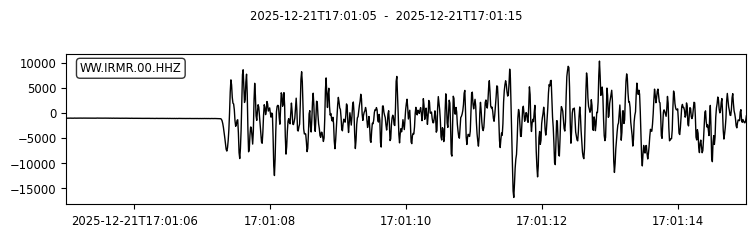

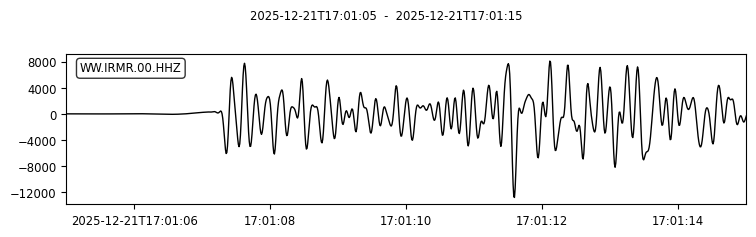

In [7]:
example_in = files[2]  # e.g., files[0]
st0 = read(str(example_in))

if OVERWRITE:
    example_out = example_in
else:
    example_out = OUT_DIR / (example_in.stem + SUFFIX + example_in.suffix)

st1 = read(str(example_out))

# Plot raw then processed
st0.plot();
st1.plot();

# Plot a zoomed-in window of the raw and processed traces
# Define start and end times
t1 = st0[0].stats.starttime + 124 # 60 seconds after start
t2 = st0[0].stats.starttime + 134  # 180 seconds after start
# Slice the trace
sliced0 = st0[0].slice(t1, t2)
sliced1 = st1[0].slice(t1, t2)
# Print information about the sliced trace
print(sliced0)
print(sliced1)
# Print the data of the sliced trace
# print(sliced.data)
sliced0.plot();
sliced1.plot();

Inventory created at 2026-02-13T02:59:45.185100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2025-12-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			WW
		Stations (1):
			WW.IRMR (Idaho Rocky Mountain Ranch, Idaho)
		Channels (3):
			WW.IRMR.00.HHZ, WW.IRMR.00.HHN, WW.IRMR.00.HHE


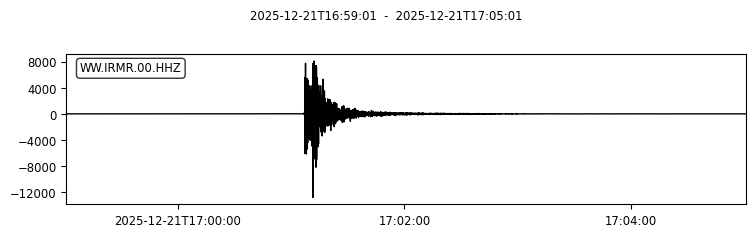

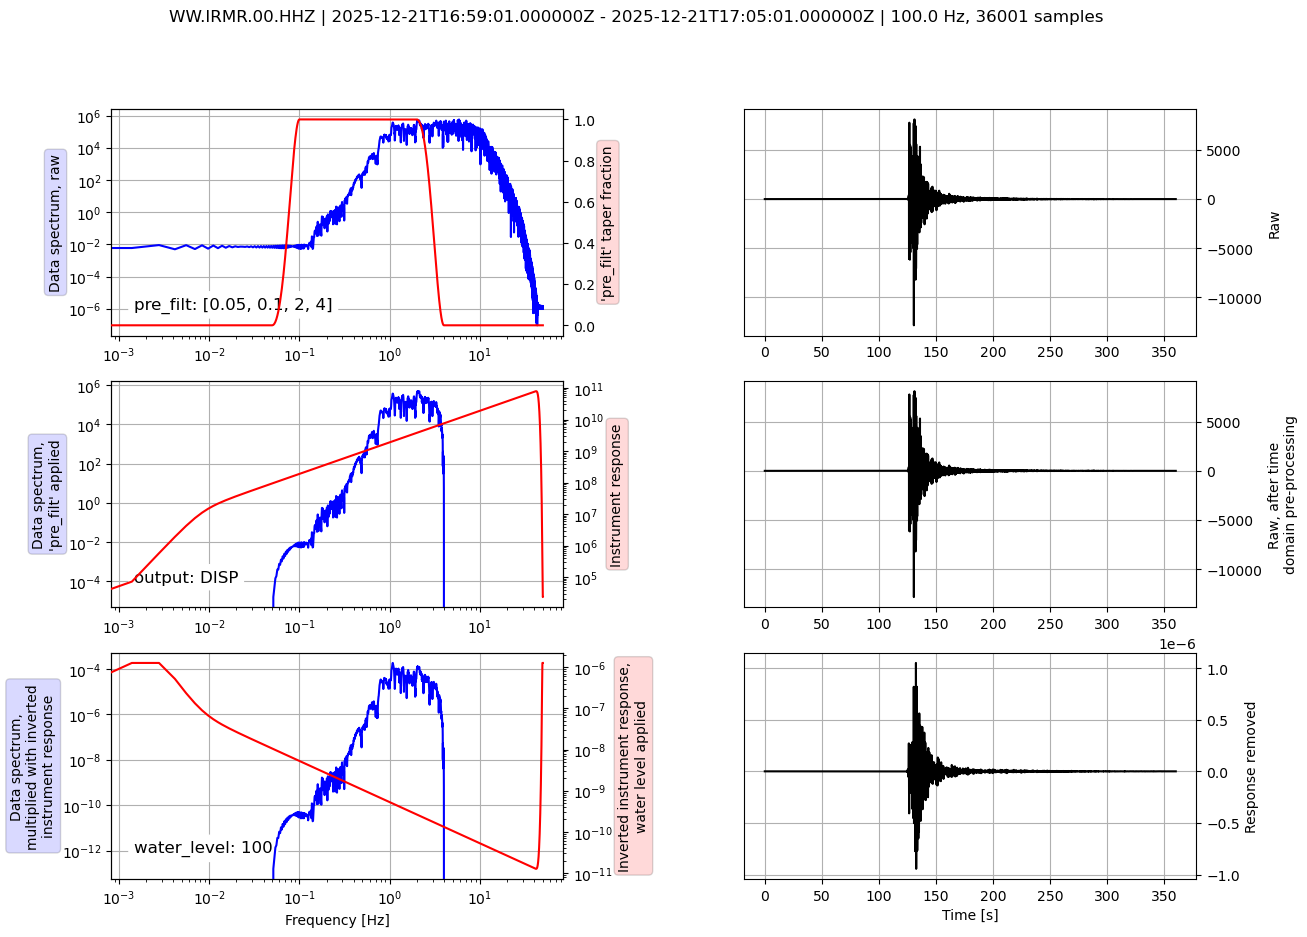

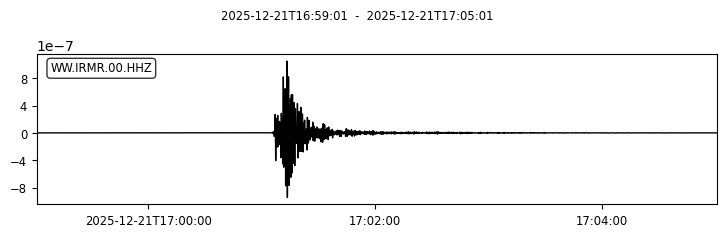

1 Trace(s) in Stream:
WW.IRMR.00.HHZ | 2025-12-21T16:59:01.000000Z - 2025-12-21T17:05:01.000000Z | 100.0 Hz, 36001 samples


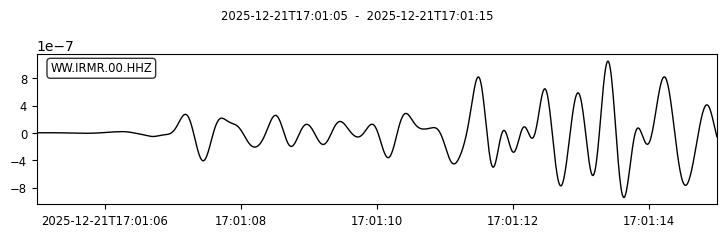

WW.IRMR.00.HHZ | 2025-12-21T17:01:05.000000Z - 2025-12-21T17:01:15.000000Z | 100.0 Hz, 1001 samples


In [9]:
# --- Fetching station metadata from IRIS FDSN web service ---
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client("IRIS")
# Fetch station metadata
inv = client.get_stations(network="WW", station="IRMR",
                                starttime=UTCDateTime("2025-12-01"),
                                endtime=UTCDateTime("2025-12-31"),
                                channel="HH?",
                                level="response")
print(inv)

# --- remove response ---
# 0. Use the pre-processed stream from above
st_copy = st.copy()
st.plot();
# 1. Define pre-filter (freqs: low-pass corner 1, low-pass 2, high-pass 1, high-pass 2)
# Frequencies should be within the valid range of the sensor
pre_filt = (0.05, 0.1, 2, 4)

# 2. Remove response (converts to Velocity in m/s)
rest = st_copy[0].remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                   water_level=100, plot=True)


# Plot raw
st_copy.plot();
print(st_copy)
# rest.plot();

# Plot zoomed-in window of the raw trace
# Define start and end times
t1 = st_copy[0].stats.starttime + 124 # 60 seconds after start
t2 = st_copy[0].stats.starttime + 134  # 180 seconds after start

# Slice the trace
sliced0 = st_copy[0].slice(t1, t2)
sliced0.plot();
# Print information about the sliced trace
print(sliced0)
# Print the data of the sliced trace
# print(sliced.data)

## Notes / Common tweaks

- To mimic SAC's `w over`, set `OVERWRITE = True`.
- If you want *new* SAC files but keep them alongside inputs, set `OUT_DIR = Path('.')`.
- For response removal, use `read_inventory()` + `st.remove_response(...)` before filtering.
- For multi-station / multi-channel workflows, you can add `st.select(...)` logic.
